In [1]:
import sys;
sys.path.append('/home/haotruong/Receipt/rece_digi/text-detection-ctpn')

In [3]:
import os

import cv2 as cv
import numpy as np
from tqdm import tqdm
from pathlib import Path

from utils.prepare.utils import orderConvex, shrink_poly

import notebook_utils as nutils

DATA_FOLDER = Path("datasets/SROIE2019/task1train/aug")

OUTPUT_LABEL = Path("datasets/SROIE2019/task1train/label")
OUTPUT_IMAGE = Path("datasets/SROIE2019/task1train/image")
OUTPUT_VIZ = Path("datasets/SROIE2019/task1train/viz")

MAX_LEN = 1200
MIN_LEN = 600

In [4]:
import shutil
# shutil.rmtree(str(OUTPUT_LABEL))
# shutil.rmtree(str(OUTPUT_IMAGE))
# shutil.rmtree(str(OUTPUT_VIZ))

OUTPUT_LABEL.mkdir()
OUTPUT_IMAGE.mkdir()
OUTPUT_VIZ.mkdir()

### Prepare dataset for training

In [ ]:
im_fns = nutils.list_files(DATA_FOLDER, "*.jpg")

for im_fn in tqdm(im_fns):
    fn = im_fn.name
    bfn, ext = im_fn.stem, im_fn.suffix

    gt_path = DATA_FOLDER / (bfn + '.txt')
    
    if not gt_path.is_file():
        print("Skip file name: " + fn)
        continue
    
    img_path = str(im_fn)

    img = cv.imread(img_path)
    img_size = img.shape
    im_size_min = np.min(img_size[0:2])
    im_size_max = np.max(img_size[0:2])

    im_scale = float(600) / float(im_size_min)
    if np.round(im_scale * im_size_max) > 1200:
        im_scale = float(1200) / float(im_size_max)
        
    if (im_scale < 0.3):
        print("Too large image: {} with {} - {}".format(fn, im_size_min, im_size_max))
        continue
        
    new_h = int(img_size[0] * im_scale)
    new_w = int(img_size[1] * im_scale)

    new_h = new_h if new_h // 16 == 0 else (new_h // 16 + 1) * 16
    new_w = new_w if new_w // 16 == 0 else (new_w // 16 + 1) * 16

    re_im = cv.resize(img, (new_w, new_h), interpolation=cv.INTER_LINEAR)
    re_size = re_im.shape

    polys = []
    with open(gt_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        splitted_line = line.strip().lower().split(',')
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, splitted_line[:8])
        poly = np.array([x1, y1, x2, y2, x3, y3, x4, y4]).reshape([4, 2])
        poly[:, 0] = poly[:, 0] / img_size[1] * re_size[1]
        poly[:, 1] = poly[:, 1] / img_size[0] * re_size[0]
        poly = orderConvex(poly)
        polys.append(poly)

        # cv.polylines(re_im, [poly.astype(np.int32).reshape((-1, 1, 2))], True,color=(0, 255, 0), thickness=2)

    res_polys = []
    for poly in polys:
        # delete polys with width less than 10 pixel
        if np.linalg.norm(poly[0] - poly[1]) < 10 or np.linalg.norm(poly[3] - poly[0]) < 10:
            continue

        res = shrink_poly(poly)
        # for p in res:
        #    cv.polylines(re_im, [p.astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 255, 0), thickness=1)

        res = res.reshape([-1, 4, 2])
        for r in res:
            x_min = np.min(r[:, 0])
            y_min = np.min(r[:, 1])
            x_max = np.max(r[:, 0])
            y_max = np.max(r[:, 1])

            res_polys.append([x_min, y_min, x_max, y_max])

    cv.imwrite(str(OUTPUT_IMAGE / fn), re_im)
    with open(OUTPUT_LABEL /  (bfn + ".txt"), "w") as f:
        for p in res_polys:
            line = ",".join(str(p[i]) for i in range(4))
            f.writelines(line + "\r\n")
#             for p in res_polys:
#                cv.rectangle(re_im,(p[0],p[1]),(p[2],p[3]),color=(0,0,255),thickness=1)

#     cv.imwrite(str(OUTPUT_VIZ / fn), re_im)

            # cv.imshow("demo",re_im)
            # cv.waitKey(0)


In [8]:
im_fns = nutils.list_files(OUTPUT_VIZ, "*.jpg")

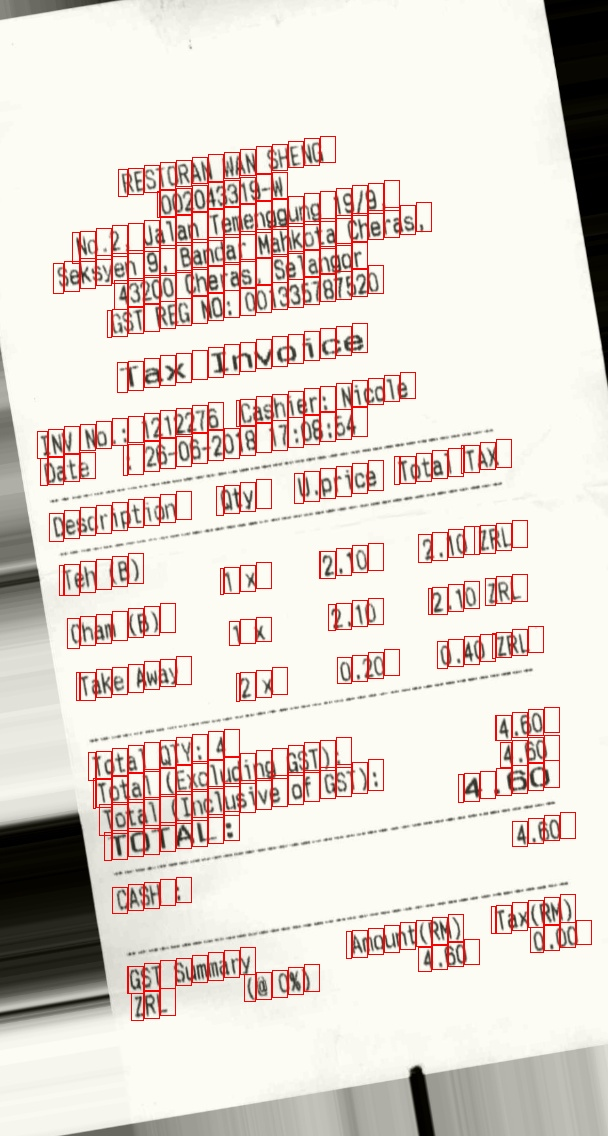

In [10]:
from IPython.display import Image
Image(filename=str(im_fns[0])) 